<a href="https://colab.research.google.com/github/reykel/machine_learning_keras_tf_owned/blob/main/01-transfer_learning_dogs_cats_resnet_v1_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from keras import layers

In [3]:
import numpy as np

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
(train_examples, validation_examples, test_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:95%]', 'train[95%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [6]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32
IMAGE_RES = 224

train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [7]:
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5", 
                                            output_shape=[2048], 
                                            trainable=False), 
                             layers.Dense(num_classes, activation='softmax')
])

model.build([None, IMAGE_RES, IMAGE_RES, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23561152  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,565,250
Trainable params: 4,098
Non-trainable params: 23,561,152
_________________________________________________________________


In [8]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

model.fit(train_batches, epochs=6, validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 75s 97ms/step - loss: 0.0532 - accuracy: 0.9810 - val_loss: 0.0472 - val_accuracy: 0.9837
Epoch 2/6
582/582 [==============================] - 59s 95ms/step - loss: 0.0310 - accuracy: 0.9896 - val_loss: 0.0477 - val_accuracy: 0.9860
Epoch 3/6
582/582 [==============================] - 57s 92ms/step - loss: 0.0230 - accuracy: 0.9922 - val_loss: 0.0525 - val_accuracy: 0.9868
Epoch 4/6
582/582 [==============================] - 58s 92ms/step - loss: 0.0190 - accuracy: 0.9935 - val_loss: 0.0506 - val_accuracy: 0.9865
Epoch 5/6
582/582 [==============================] - 57s 92ms/step - loss: 0.0157 - accuracy: 0.9942 - val_loss: 0.0499 - val_accuracy: 0.9854
Epoch 6/6
582/582 [==============================] - 60s 96ms/step - loss: 0.0143 - accuracy: 0.9952 - val_loss: 0.0632 - val_accuracy: 0.9837


In [9]:
image_batch, label_batch = next(iter(test_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

In [10]:
predicted_batch = model.predict(image_batch)

1/1 [==============================] - 0s 453ms/step


In [11]:
predicted_ids = np.argmax(predicted_batch, axis=-1)

In [12]:
for i in range(0,len(predicted_ids)):
  print(str(predicted_ids[i]) + " - " + str(label_batch[i]))

0 - 0
0 - 0
1 - 1
1 - 1
1 - 1
0 - 0
0 - 0
1 - 1
1 - 1
1 - 1
1 - 1
0 - 0
1 - 1
0 - 0
1 - 1
0 - 0
0 - 0
0 - 0
0 - 0
1 - 1
0 - 0
0 - 0
1 - 1
0 - 0
0 - 0
1 - 1
0 - 0
0 - 0
0 - 0
0 - 0
0 - 0
0 - 0


In [13]:
cm = confusion_matrix(label_batch, predicted_ids)

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


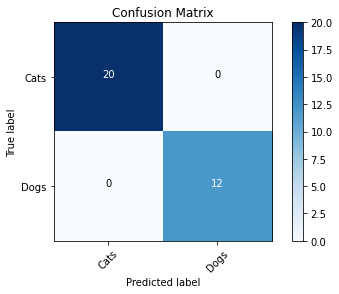

In [15]:
cm_plot_labels = ['Cats','Dogs']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')